In [8]:
import sympy
import random
import numpy as np
import matplotlib.pyplot as plt
import pymysql.cursors

### Creating a hash function to convert URL text into a large integer
    The integer value can be represented by sum of ASCII value of each character in url multiplied by (128 to the power of the character index)

In [9]:
#Create a hash function for text - converting it first into an integer
def strToInt(str1):
    value = 0
    for n, c in enumerate(str1):
        value += ord(c) * 128**n
    return value

### Random Code Generator for the Shortened URL

In [10]:
def genCode():
    rands = list(range(48, 58)) + list(range(65, 91)) + list(range(97, 123))
    code = ''
    while len(code) < 8:
        code += chr(random.choice(rands))
    return code

### Read the list of URLs in dataset

In [11]:
# Read All definitions from the dictionary file
'''
f = open('urls.txt',"r")
urls = []
for line in f:
    urls.append(line.strip())


print('Length of All URLs in dataset:', len(urls))
random.shuffle(urls)
url_tostore = urls[:12500] #URLs to be sotred in the database
url_toquery = urls[10000:15000] #Items to be queried
'''

f = open('queryLinks.csv',"r")
urls_toquery = []
for line in f:
    urls_toquery.append(line.strip()) #first 2500 are stored in the database, second 2500 aren't stored

f = open('dbSummary.csv',"r")
urls_tostore = []
for line in f:
    line = line.split(',')
    urls_tostore.append(line[0]) #stored urls in the database


print('Length of URLs to be stored:', len(urls_tostore))
print('Length of All URLs to be queried:', len(urls_toquery))

Length of URLs to be stored: 12492
Length of All URLs to be queried: 4949


## Generate Standard Bloom Filter

In [12]:
class stdFilter:
    def __init__(self, M, NHash, maxParam):
        #Initialize Filter Table with Zeros
        self.M = M # --> 0
        self.maxParam = maxParam #--> 0
        self.bloomTable = np.zeros((M, 1), dtype = bool) #--> 1
        self.tableSize = self.bloomTable.nbytes / 1024 / 8 #--> 2

        # P - Primes Generator for Universal Hash Functions
        #e.g.: NHash = 3, P = [33018497, 20314969, 30891281]    
        self.P = [] #--> 3
        while len(self.P) < NHash:
            p = sympy.randprime(M, 2*M)
            if p not in self.P:
                self.P.append(p)

        # A, B - Random Generation for Parameters a, b of each Universal Hash Function 
        #e.g.: NHash = 3, A = [50725, 28788, 38992], B = [74739, 53707, 13081]
        self.A = [] #--> 4
        self.B = [] #--> 5
        firstVisA = 1
        firstVisB = 1
        while len(self.A) < NHash:
            while firstVisA == 1 or (a in self.A):
                a = random.randint(1, self.maxParam)
                firstVisA = 0

            while firstVisB == 1 or (b in self.B):
                b = random.randint(1, self.maxParam)
                firstVisB = 0

            self.A.append(a)
            self.B.append(b)
#        self.A=[1499, 365, 7656]

#        self.B=[3207, 5843, 5601] 
#        self.P=[62129, 79627, 78901]
    

    # Query the Filter for a certain Code
    def queryFilter(self, word):
        notFound = False
        strVal = strToInt(word)
        for a, b, p in zip(self.A, self.B, self.P):
            x = ((strVal * a + b)%p)%self.M
            if self.bloomTable[x] != True:
                notFound = True
                break
        return notFound
    
    # Store The URL in DB and insert into filter Table
    def insert(self, code):
        strVal = strToInt(code)
        for a, b, p in zip(self.A, self.B, self.P):
            x = ((strVal * a + b)%p)%self.M
            self.bloomTable[x] = True

        #updateDB(code, url, self.dbName, self.tName) #Insert to Database

### Check by  inserting and query on filter 

In [113]:
# Create standard filter and insert values
fil1 = stdFilter(100000, 3, 10000)
codes = []
for url in urls_tostore:
    notFound = False
    code = ''
    while notFound == False:
        code = genCode() #Generate Random Code Corresponding to the URL
        notFound = fil1.queryFilter(code)
    
    codes.append(code)
    fil1.insert(code)

In [114]:
# generate codes to check for false negatives
codes_fp = []
for url in urls_toquery:
    if url in urls_tostore:
        pass
    else:
        code = genCode()
        while code in codes:
            code = genCode()
        
        codes_fp.append(code)

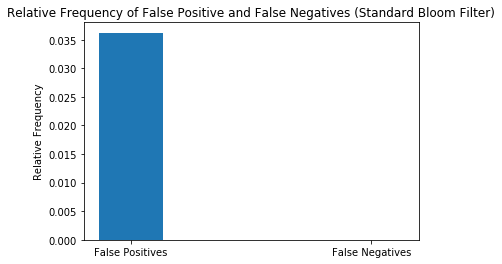

In [115]:
#Query all possible words (Try to retreive them)
fp = 0
fn = 0
for code in codes:
    queryRes = fil1.queryFilter(code)
    if queryRes == True:
        fn += 1
for code in codes_fp:
    queryRes = fil1.queryFilter(code)
    if queryRes == False:
        fp += 1
        
plt.bar([1,4], [fp/len(codes_fp), fn/len(code)])
plt.xticks([1,4], ['False Positives', 'False Negatives'])
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency of False Positive and False Negatives (Standard Bloom Filter)')
plt.show()

## Generate Ternary Bloom Filter

In [13]:
class terFilter:
    def __init__(self, M, NHash, maxParam):
        #Initialize Filter Table with Zeros
        self.M = M 
        self.maxParam = maxParam 
        self.bloomTable = np.zeros((M, 1), dtype = 'int8') 
        self.tableSize = self.bloomTable.nbytes / 1024 / 4 

        # P - Primes Generator for Universal Hash Functions
        #e.g.: NHash = 3, P = [33018497, 20314969, 30891281]    
        self.P = [] #--> 3
        while len(self.P) < NHash:
            p = sympy.randprime(M, 2*M)
            if p not in self.P:
                self.P.append(p)

        # A, B - Random Generation for Parameters a, b of each Universal Hash Function 
        #e.g.: NHash = 3, A = [50725, 28788, 38992], B = [74739, 53707, 13081]
        self.A = [] 
        self.B = [] 
        firstVisA = 1
        firstVisB = 1
        while len(self.A) < NHash:
            while firstVisA == 1 or (a in self.A):
                a = random.randint(1, self.maxParam)
                firstVisA = 0

            while firstVisB == 1 or (b in self.B):
                b = random.randint(1, self.maxParam)
                firstVisB = 0

            self.A.append(a)
            self.B.append(b)
        

    # Query the Filter for a certain Code
    def queryFilter(self, code):
        notFound = False
        flag = False
        strVal = strToInt(code)
        for a, b, p in zip(self.A, self.B, self.P):
            x = ((strVal * a + b)%p)%self.M
            if self.bloomTable[x] == 0:
                notFound = True
                break
            elif self.bloomTable[x] == 1:
                flag = True
                
        if notFound == True:
            return -1 # -1 = element not found
        elif flag == False:
            return 0
        else:
            return 1 #1 = element foundTrue
    
    
    # Store The URL in DB and insert into filter Table
    def insert(self, code):
        strVal = strToInt(code)
        for a, b, p in zip(self.A, self.B, self.P):
            x = ((strVal * a + b)%p)%self.M
            self.bloomTable[x] += 1
            if self.bloomTable[x] > 2:
                self.bloomTable[x] = 2
    
    # Delete an Element from the Table
    def delete(self, code):
        res = self.queryFilter(code)
        if res == 1:
            strVal = strToInt(code)
            for a, b, p in zip(self.A, self.B, self.P):
                x = ((strVal * a + b)%p)%self.M
                if self.bloomTable[x] == 1:
                    self.bloomTable[x] = 0        

### Check by  inserting and query on filter

In [109]:
# Create ternary filter and insert values
fil2 = terFilter(100000, 3, 10000)
codes_ter = []
for url in urls_tostore:
    res = 1
    code = ''
    while res == 1 or res == 0:
        code = genCode() #Generate Random Code Corresponding to the URL
        res = fil2.queryFilter(code)
        #print('code:', code, ' --- url:', url)
    
    codes_ter.append(code)
    fil2.insert(code)

In [110]:
# Create new codes for checking false positives
codes_fp_ter = []
for url in urls_toquery:
    if url in urls_tostore:
        pass
    else:
        code = genCode()
        while code in codes_ter:
            code = genCode()
        
        codes_fp_ter.append(code)

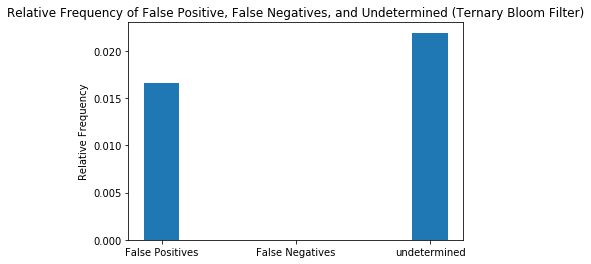

In [111]:
#Query all possible words (Try to retreive them)
fp = 0
fn = 0
undet = 0
for code in codes_ter:
    queryRes = fil2.queryFilter(code)
    #print(queryRes)
    if queryRes == -1:
        fn += 1
    elif queryRes == 0:
        undet += 1
        
for code in codes_fp_ter:
    queryRes = fil2.queryFilter(code)
    #print(queryRes)
    if queryRes == 1:
        fp += 1
    elif queryRes == 0:
        undet += 1
        
plt.bar([1, 4, 7], [fp/len(urls_toquery), fn/len(codes_fp_ter), undet/len(codes_ter)])
plt.xticks([1, 4, 7], ['False Positives', 'False Negatives', 'undetermined'])
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency of False Positive, False Negatives, and Undetermined (Ternary Bloom Filter)')
plt.show()

## AutoScaling Bloom Filter 

In [14]:
class autoFilter:
    def __init__(self, M, NHash, maxParam,theta,T):
        #Initialize Filter Table with Zeros
        
        self.M = M 
        self.maxParam = maxParam 
        self.theta=theta # Theta : Threshold of count to set bit as positive in table
        self.T=T  #T: Threshold of dot product with table to consider element as existing in table.
        self.countTable=np.zeros(M,dtype= int)
        self.bloomTable = np.zeros(M, dtype = int) 
        self.tableSize = self.bloomTable.nbytes / 1024 / 8 

        # P - Primes Generator for Universal Hash Functions
        #e.g.: NHash = 3, P = [33018497, 20314969, 30891281]    
        self.P = [] 
        while len(self.P) < NHash:
            p = sympy.randprime(M, 2*M)
            if p not in self.P:
                self.P.append(p)

        # A, B - Random Generation for Parameters a, b of each Universal Hash Function 
        #e.g.: NHash = 3, A = [50725, 28788, 38992], B = [74739, 53707, 13081]
        self.A = [] 
        self.B = [] 
        firstVisA = 1
        firstVisB = 1
        while len(self.A) < NHash:
            while firstVisA == 1 or (a in self.A):
                a = random.randint(1, self.maxParam)
                firstVisA = 0

            while firstVisB == 1 or (b in self.B):
                b = random.randint(1, self.maxParam)
                firstVisB = 0

            self.A.append(a)
            self.B.append(b)

    # Query the Filter for a certain Code
    def queryFilter(self, word):
        strVal = strToInt(word)
        res=np.zeros(self.M,dtype=int)
        for a, b, p in zip(self.A,self.B,self.P):
            x = ((strVal * a + b)%p)%self.M
            res[x]=1
        dp=np.dot(res,self.bloomTable)
        if(dp>self.T):
            notFound=False
        else:
            notFound=True
        return notFound
    # insert into filter Table
    def insert(self, code):
        notFound = True
        strVal = strToInt(code)
        for a, b, p in zip(self.A, self.B, self.P):
            x = ((strVal * a + b)%p)%self.M
            self.countTable[x]+=1
            if(self.countTable[x]>self.theta):
                self.bloomTable[x] = 1
    #Delete code from Table
    def delete(self, code):
            notFound = self.queryFilter(code)
            if notFound == False:
                strVal = strToInt(code)
                for a, b, p in zip(self.A, self.B, self.P):
                    x = ((strVal * a + b)%p)%self.M
                    if self.countTable[x] > 0:
                        self.countTable[x]-=1
                        if(self.countTable[x]<=self.theta):
                            self.bloomTable[x]=0

### Check by  inserting and query on filter


In [256]:
#Generate AutoFilter and generate and enter codes to filter
fil3 = autoFilter(100000, 10, 10000,2,1)
codes3 = []
for url in urls_tostore:
    res = 1
    code = ''
    notFound=False
    while notFound == False:
        code = genCode() #Generate Random Code Corresponding to the URL
        notFound = fil3.queryFilter(code)
    codes3.append(code)
    fil3.insert(code)

In [257]:
#Generate alternate codes not entered in filter
codes_fp3 =[]
for url in urls_toquery:
    if url in urls_tostore:
        pass
    else:
        code = genCode()
        while code in codes3:
            code = genCode()
        
        codes_fp3.append(code)

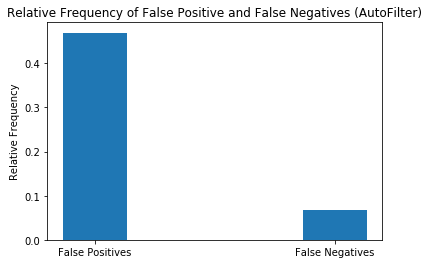

In [258]:
#Query all possible words (Try to retreive them)
fp = 0
fn = 0
for code in codes3:
    queryRes = fil3.queryFilter(code)
    if queryRes == True:
        fn += 1
for code in codes_fp3:
    queryRes = fil3.queryFilter(code)
    if queryRes == False:
        fp += 1
        
plt.bar([1,4], [fp/len(codes_fp3), fn/len(codes3)])
plt.xticks([1,4], ['False Positives', 'False Negatives'])
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency of False Positive and False Negatives (AutoFilter)')
plt.show()

## Counting Bloom Filter

In [15]:
class countingFilter:
    def __init__(self, M, NHash, maxParam):
        #Initialize Filter Table with Zeros
        self.M = M # --> 0
        self.maxParam = maxParam #--> 0
        self.countTable=np.zeros(M,dtype= int)

        # P - Primes Generator for Universal Hash Functions
        #e.g.: NHash = 3, P = [33018497, 20314969, 30891281]    
        self.P = [] #--> 3
        while len(self.P) < NHash:
            p = sympy.randprime(M, 2*M)
            if p not in self.P:
                self.P.append(p)

        # A, B - Random Generation for Parameters a, b of each Universal Hash Function 
        #e.g.: NHash = 3, A = [50725, 28788, 38992], B = [74739, 53707, 13081]
        self.A = [] #--> 4
        self.B = [] #--> 5
        firstVisA = 1
        firstVisB = 1
        while len(self.A) < NHash:
            while firstVisA == 1 or (a in self.A):
                a = random.randint(1, self.maxParam)
                firstVisA = 0

            while firstVisB == 1 or (b in self.B):
                b = random.randint(1, self.maxParam)
                firstVisB = 0

            self.A.append(a)
            self.B.append(b)
            
    # Query the Filter for a certain Code
    def queryFilter(self, word):
        strVal = strToInt(word)
        notfound=False
        for a, b, p in zip(self.A,self.B,self.P):
            x = ((strVal * a + b)%p)%self.M
            if self.countTable[x] == 0:
                notfound=True
                break
        return notfound
    
    # Store The URL in DB and insert into filter Table
    def insert(self, code):
        strVal = strToInt(code)
        for a, b, p in zip(self.A, self.B, self.P):
            x = ((strVal * a + b)%p)%self.M
            self.countTable[x]+=1
    def delete(self, code):
            notFound = self.queryFilter(code)
            if notFound == False:
                strVal = strToInt(code)
                for a, b, p in zip(self.A, self.B, self.P):
                    x = ((strVal * a + b)%p)%self.M
                    if self.countTable[x] > 0:
                        self.countTable[x]-=1

In [231]:
# Generate counting filter instance, generate and enter codes
fil4 = countingFilter(100000, 3, 10000)
codes = []
for ind,url in enumerate(urls_tostore):
    res = 1
    code = ''
    notFound=False
    while notFound == False:
        code = genCode() #Generate Random Code Corresponding to the URL
        notFound = fil4.queryFilter(code)
    
    codes.append(code)
    fil4.insert(code)

In [232]:
# Generate other codes for analysis
codes_fp = []
for url in urls_toquery:
    if url in urls_tostore:
        pass
    else:
        code = genCode()
        while code in codes:
            code = genCode()
        
        codes_fp.append(code)

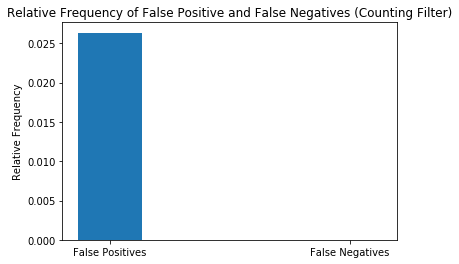

In [233]:
#Query all possible words (Try to retreive them)
fp = 0
fn = 0
for code in codes:
    queryRes = fil4.queryFilter(code)
    if queryRes == True:
        fn += 1
for code in codes_fp:
    queryRes = fil4.queryFilter(code)
    if queryRes == False:
        fp += 1
        
plt.bar([1,4], [fp/len(codes_fp), fn/len(codes)])
plt.xticks([1,4], ['False Positives', 'False Negatives'])
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency of False Positive and False Negatives (Counting Filter)')
plt.show()

## Deletable Bloom Filter

In [16]:
class deletableFilter:
    def __init__(self, M, NHash, maxParam,subSize):
        #Initialize Filter Table with Zeros
        self.M = M # --> 0
        self.maxParam = maxParam #--> 0
        self.subSize=subSize
        self.matchTable=np.zeros((int(np.ceil(float(M)/(float(subSize)))),1),dtype= bool)
        self.bloomTable = np.zeros((M, 1), dtype = bool) #--> 1
        self.tableSize = self.bloomTable.nbytes / 1024 / 8 #--> 2

        # P - Primes Generator for Universal Hash Functions
        #e.g.: NHash = 3, P = [33018497, 20314969, 30891281]    
        self.P = [] #--> 3
        while len(self.P) < NHash:
            p = sympy.randprime(M, 2*M)
            if p not in self.P:
                self.P.append(p)

        # A, B - Random Generation for Parameters a, b of each Universal Hash Function 
        #e.g.: NHash = 3, A = [50725, 28788, 38992], B = [74739, 53707, 13081]
        self.A = [] #--> 4
        self.B = [] #--> 5
        firstVisA = 1
        firstVisB = 1
        while len(self.A) < NHash:
            while firstVisA == 1 or (a in self.A):
                a = random.randint(1, self.maxParam)
                firstVisA = 0

            while firstVisB == 1 or (b in self.B):
                b = random.randint(1, self.maxParam)
                firstVisB = 0

            self.A.append(a)
            self.B.append(b)
        
    # Query the Filter for a certain Code
    def queryFilter(self, word):
        notFound = False
        strVal = strToInt(word)
        for a, b, p in zip(self.A,self.B,self.P):
            x = ((strVal * a + b)%p)%self.M
            if self.bloomTable[x] != 1:
                notFound = True
                break
        return notFound
    
    # Store The URL in DB and insert into filter Table
    def insert(self, code):
        strVal = strToInt(code)
        for a, b, p in zip(self.A, self.B, self.P):
            x = ((strVal * a + b)%p)%self.M
            self.bloomTable[x]=1
            if(self.bloomTable[x]==1):
                section=int(x/self.subSize)
                self.matchTable[section]=1
            
    def delete(self, code):
            notFound = self.queryFilter(code)
            if notFound == False:
                strVal = strToInt(code)
                for a, b, p in zip(self.A, self.B, self.P):
                    x = ((strVal * a + b)%p)%self.M
                    section=int(x/self.subSize)
                    if(self.matchTable[section]!=1):
                        self.bloomTable[x]=0

In [142]:
# Generate Deletable Filter. Generate and insert codes
fil5 = deletableFilter(100000, 3, 10000,10)
codes = []
for url in urls_tostore:
    res = 1
    code = ''
    notFound=False
    while notFound == False:
        code = genCode() #Generate Random Code Corresponding to the URL
        notFound = fil5.queryFilter(code)
    
    codes.append(code)
    fil5.insert(code)

In [143]:
# Generate alternate codes for checking false positives
codes_fp = []
for url in urls_toquery:
    if url in urls_tostore:
        pass
    else:
        code = genCode()
        while code in codes:
            code = genCode()
        
        codes_fp.append(code)

12492
91


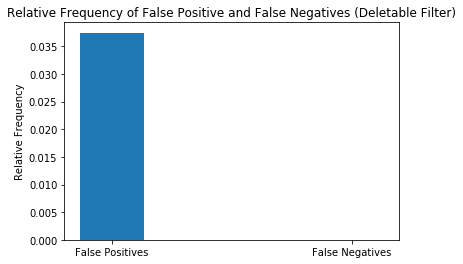

In [144]:
#Query all possible words (Try to retreive them)
fp = 0
fn = 0
for code in codes:
    queryRes = fil5.queryFilter(code)
    if queryRes == True:
        fn += 1
for code in codes_fp:
    queryRes = fil5.queryFilter(code)
    if queryRes == False:
        fp += 1
print(len(codes))
print(fp)
        
plt.bar([1,4], [fp/len(codes_fp), fn/len(codes)])
plt.xticks([1,4], ['False Positives', 'False Negatives'])
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency of False Positive and False Negatives (Deletable Filter)')
plt.show()

## Comparison of false positives 

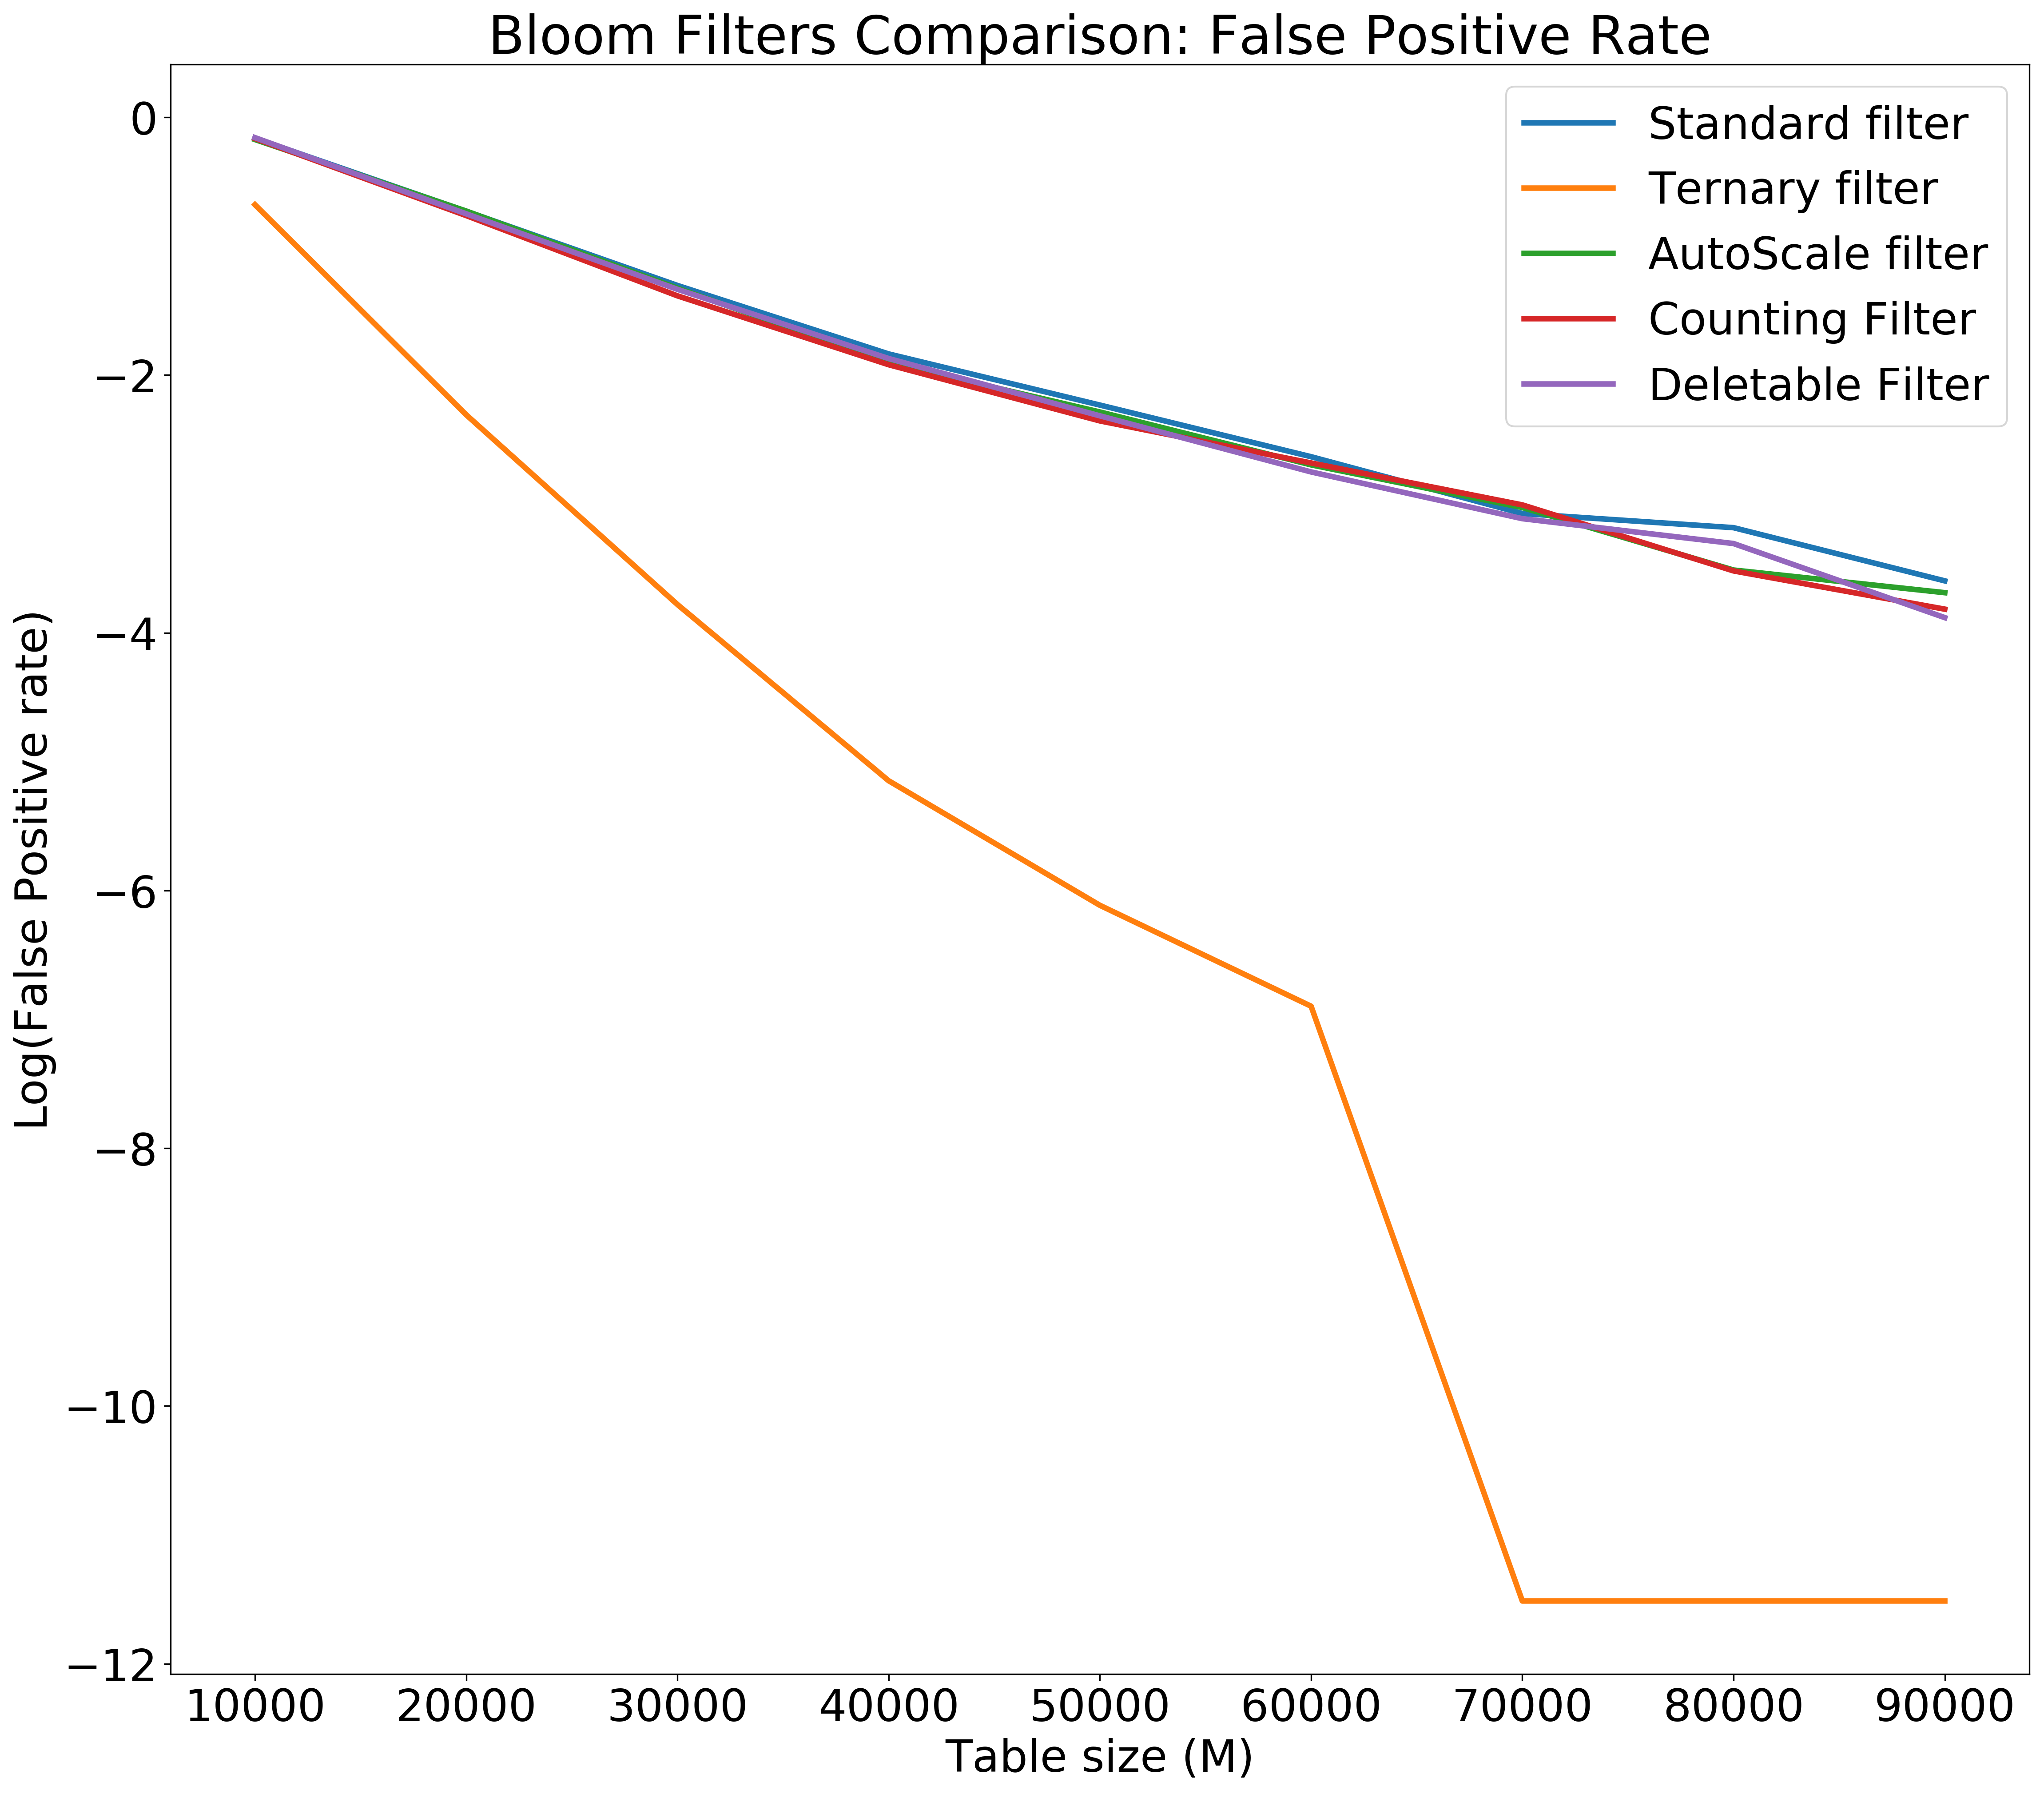

In [303]:
#Generation of codes
codes=[]
for i in range(0,10000):
    codes.append(genCode())
check_code=[]
#generation of additional codes for false positive check
for i in range(0,5000):
    check_code.append(genCode())
M=np.arange(10000,100000,10000)
filter_list=[[],[],[],[],[]]
# Change table size and check filter false positives
for m in M:
    filters=[]
    filters.append(stdFilter(m, 3, m/10))
    filters.append(terFilter(m, 3, m/10))
    filters.append(autoFilter(m,3,m/10,0,2))
    filters.append(countingFilter(m, 3, m/10))
    filters.append(deletableFilter(m, 3, m/10,10))
    for code in codes:
        for fil in filters:
            fil.insert(code)
    
    for i,fil in enumerate(filters):
        fp=0
        for code in check_code:
            if(not fil.queryFilter(code)):
                fp+=1
        filter_list[i].append(float(fp)/float(5000))
        
plt.rcParams.update({'font.size': 24})        
filter_list[1]=np.array(filter_list[1])+0.00001
fig=plt.figure(figsize=(18, 16),dpi= 300, facecolor='w', edgecolor='k')
plt.plot(M,np.log(filter_list[0]),label='Standard filter',linewidth=3)
plt.plot(M,np.log(filter_list[1]),label='Ternary filter',linewidth=3)
plt.plot(M,np.log(filter_list[2]),label='AutoScale filter',linewidth=3)
plt.plot(M,np.log(filter_list[3]),label='Counting Filter',linewidth=3)
plt.plot(M,np.log(filter_list[4]),label='Deletable Filter',linewidth=3)
plt.legend()
plt.title('Bloom Filters Comparison: False Positive Rate')
plt.xlabel('Table size (M)')
plt.ylabel('Log(False Positive rate)')
plt.show()

    

## Comparison for flase negatives on deletion

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.021602160216021602, 0.021370670596904937, 0.0210023335926214, 0.020120014119308152, 0.020752594074259282, 0.020669422589678625, 0.02100300042863266, 0.02108016617941222, 0.021003500583430573, 0.020912893253318784, 0.021404280856171236], [0.1844184418441844, 0.21886514369933677, 0.2581397933103678, 0.29968231556653724, 0.3455431928991124, 0.39751966928923854, 0.4500642948992713, 0.50715494691491, 0.5582597099516586, 0.6068376068376068, 0.6589317863572715], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


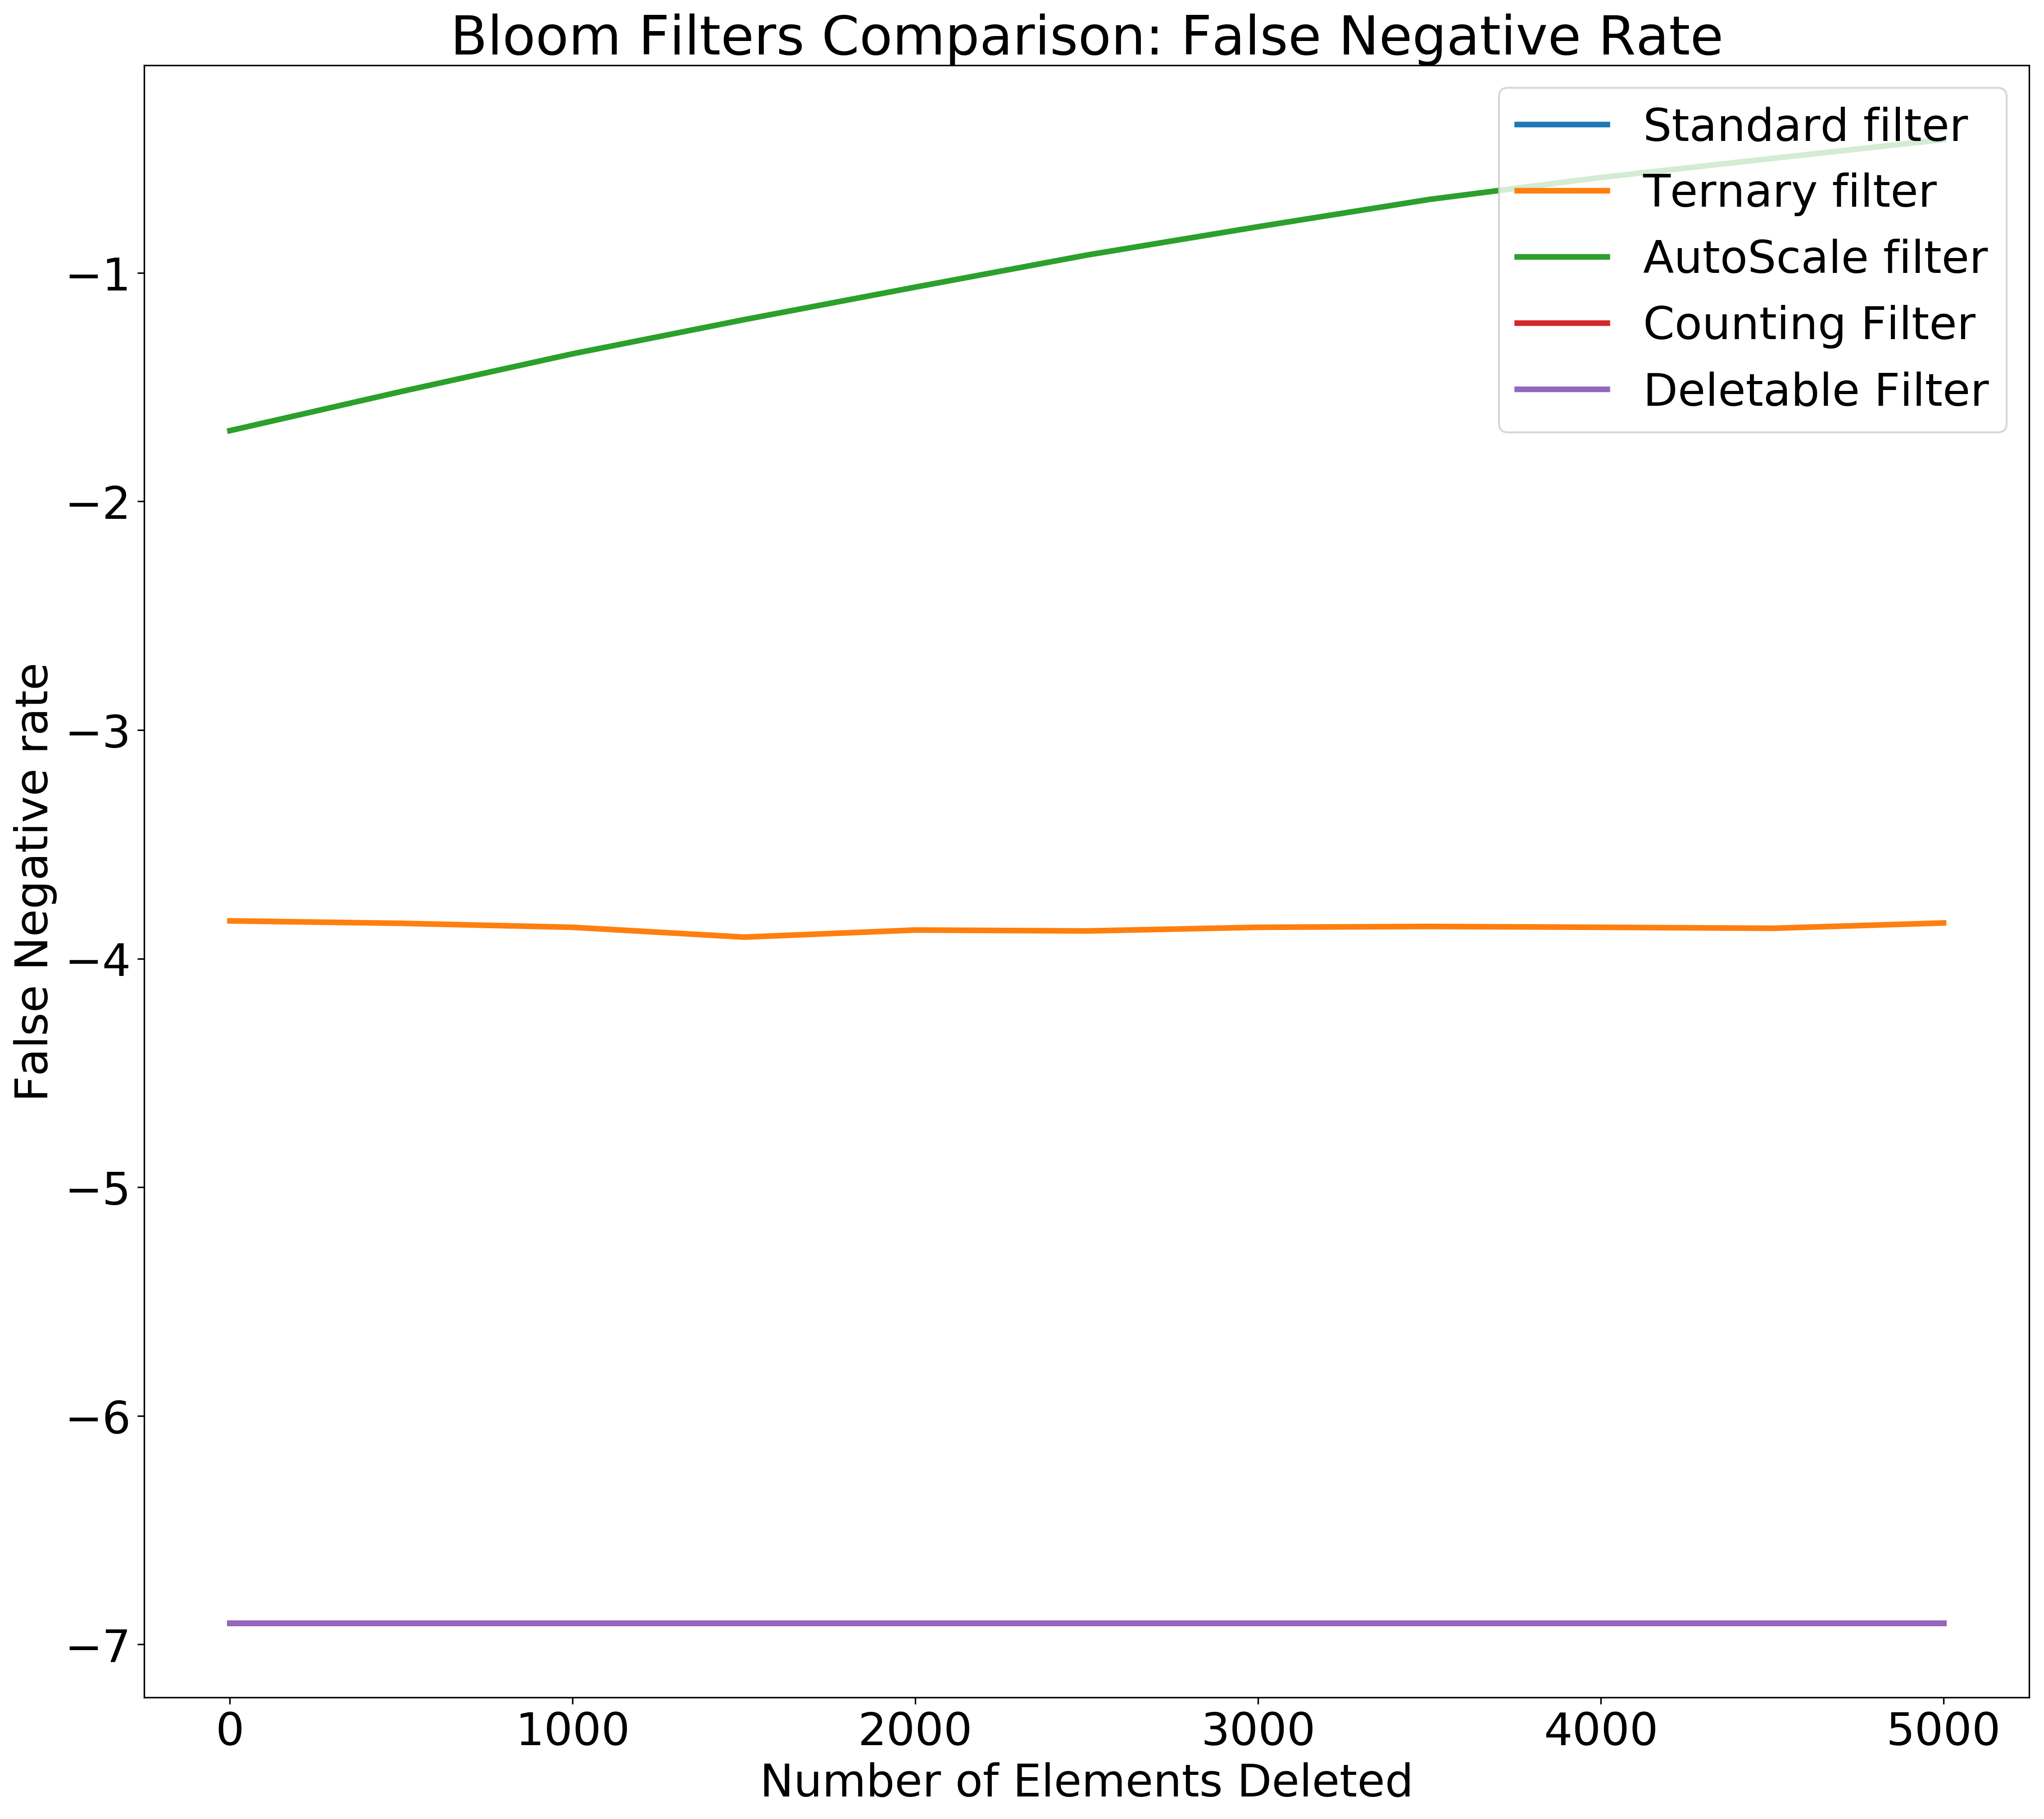

In [18]:
codes=[]
for i in range(0,10000):
    codes.append(genCode())
# Generation of filters 
m=100000
filter_list=[[],[],[],[],[]]
filters=[]
I=[]
filters.append(stdFilter(m, 3, m/10))
filters.append(terFilter(m, 3, m/10))
filters.append(autoFilter(m,10,m/10,2,1))
filters.append(countingFilter(m, 3, m/10))
filters.append(deletableFilter(m, 3, m/10,10))
remaining=codes.copy()

# Add codes in filters
for code in codes:
    for fil in filters:
        fil.insert(code)
# Delete codes and check for false negatives
for i,code in enumerate(codes):
    for fil in [1,2,3,4]:
        filters[fil].delete(code)
    remaining.remove(code)
    
    if(i%500==0):
        for ind,fil in enumerate(filters):
            fn=0
            for c in remaining:
                qr=fil.queryFilter(c)
                if(ind!=1):
                    if(qr):
                        fn+=1
                else:
                    if(qr!=1):
                        fn+=1
            filter_list[ind].append(float(fn)/float(len(remaining)))
        I.append(i)
    if(i==5000):
        break
print(filter_list)
print(I)
for i in [0,3,4]:
    filter_list[i]=np.array(filter_list[i])+0.001
plt.rcParams.update({'font.size': 24})
fig=plt.figure(figsize=(18, 16),dpi= 300, facecolor='w', edgecolor='k')
plt.plot(I,np.log(filter_list[0]),label='Standard filter',linewidth=3)
plt.plot(I,np.log(filter_list[1]),label='Ternary filter',linewidth=3)
plt.plot(I,np.log(filter_list[2]),label='AutoScale filter',linewidth=3)
plt.plot(I,np.log(filter_list[3]),label='Counting Filter',linewidth=3)
plt.plot(I,np.log(filter_list[4]),label='Deletable Filter',linewidth=3)
plt.legend()
plt.title('Bloom Filters Comparison: False Negative Rate')
plt.xlabel('Number of Elements Deleted')
plt.ylabel('False Negative rate')
plt.show()


    

## Comparison of false positives progression on deletion

[[0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.02292, 0.02276, 0.02234, 0.02134, 0.02048, 0.0193, 0.01774, 0.01604, 0.01406, 0.01222, 0.01006], [0.0218, 0.0198, 0.0172, 0.015, 0.0132, 0.011, 0.0086, 0.0066, 0.0054, 0.0038, 0.0026], [0.0198, 0.0198, 0.0198, 0.0198, 0.0198, 0.0198, 0.0198, 0.0198, 0.0198, 0.0198, 0.0198]]


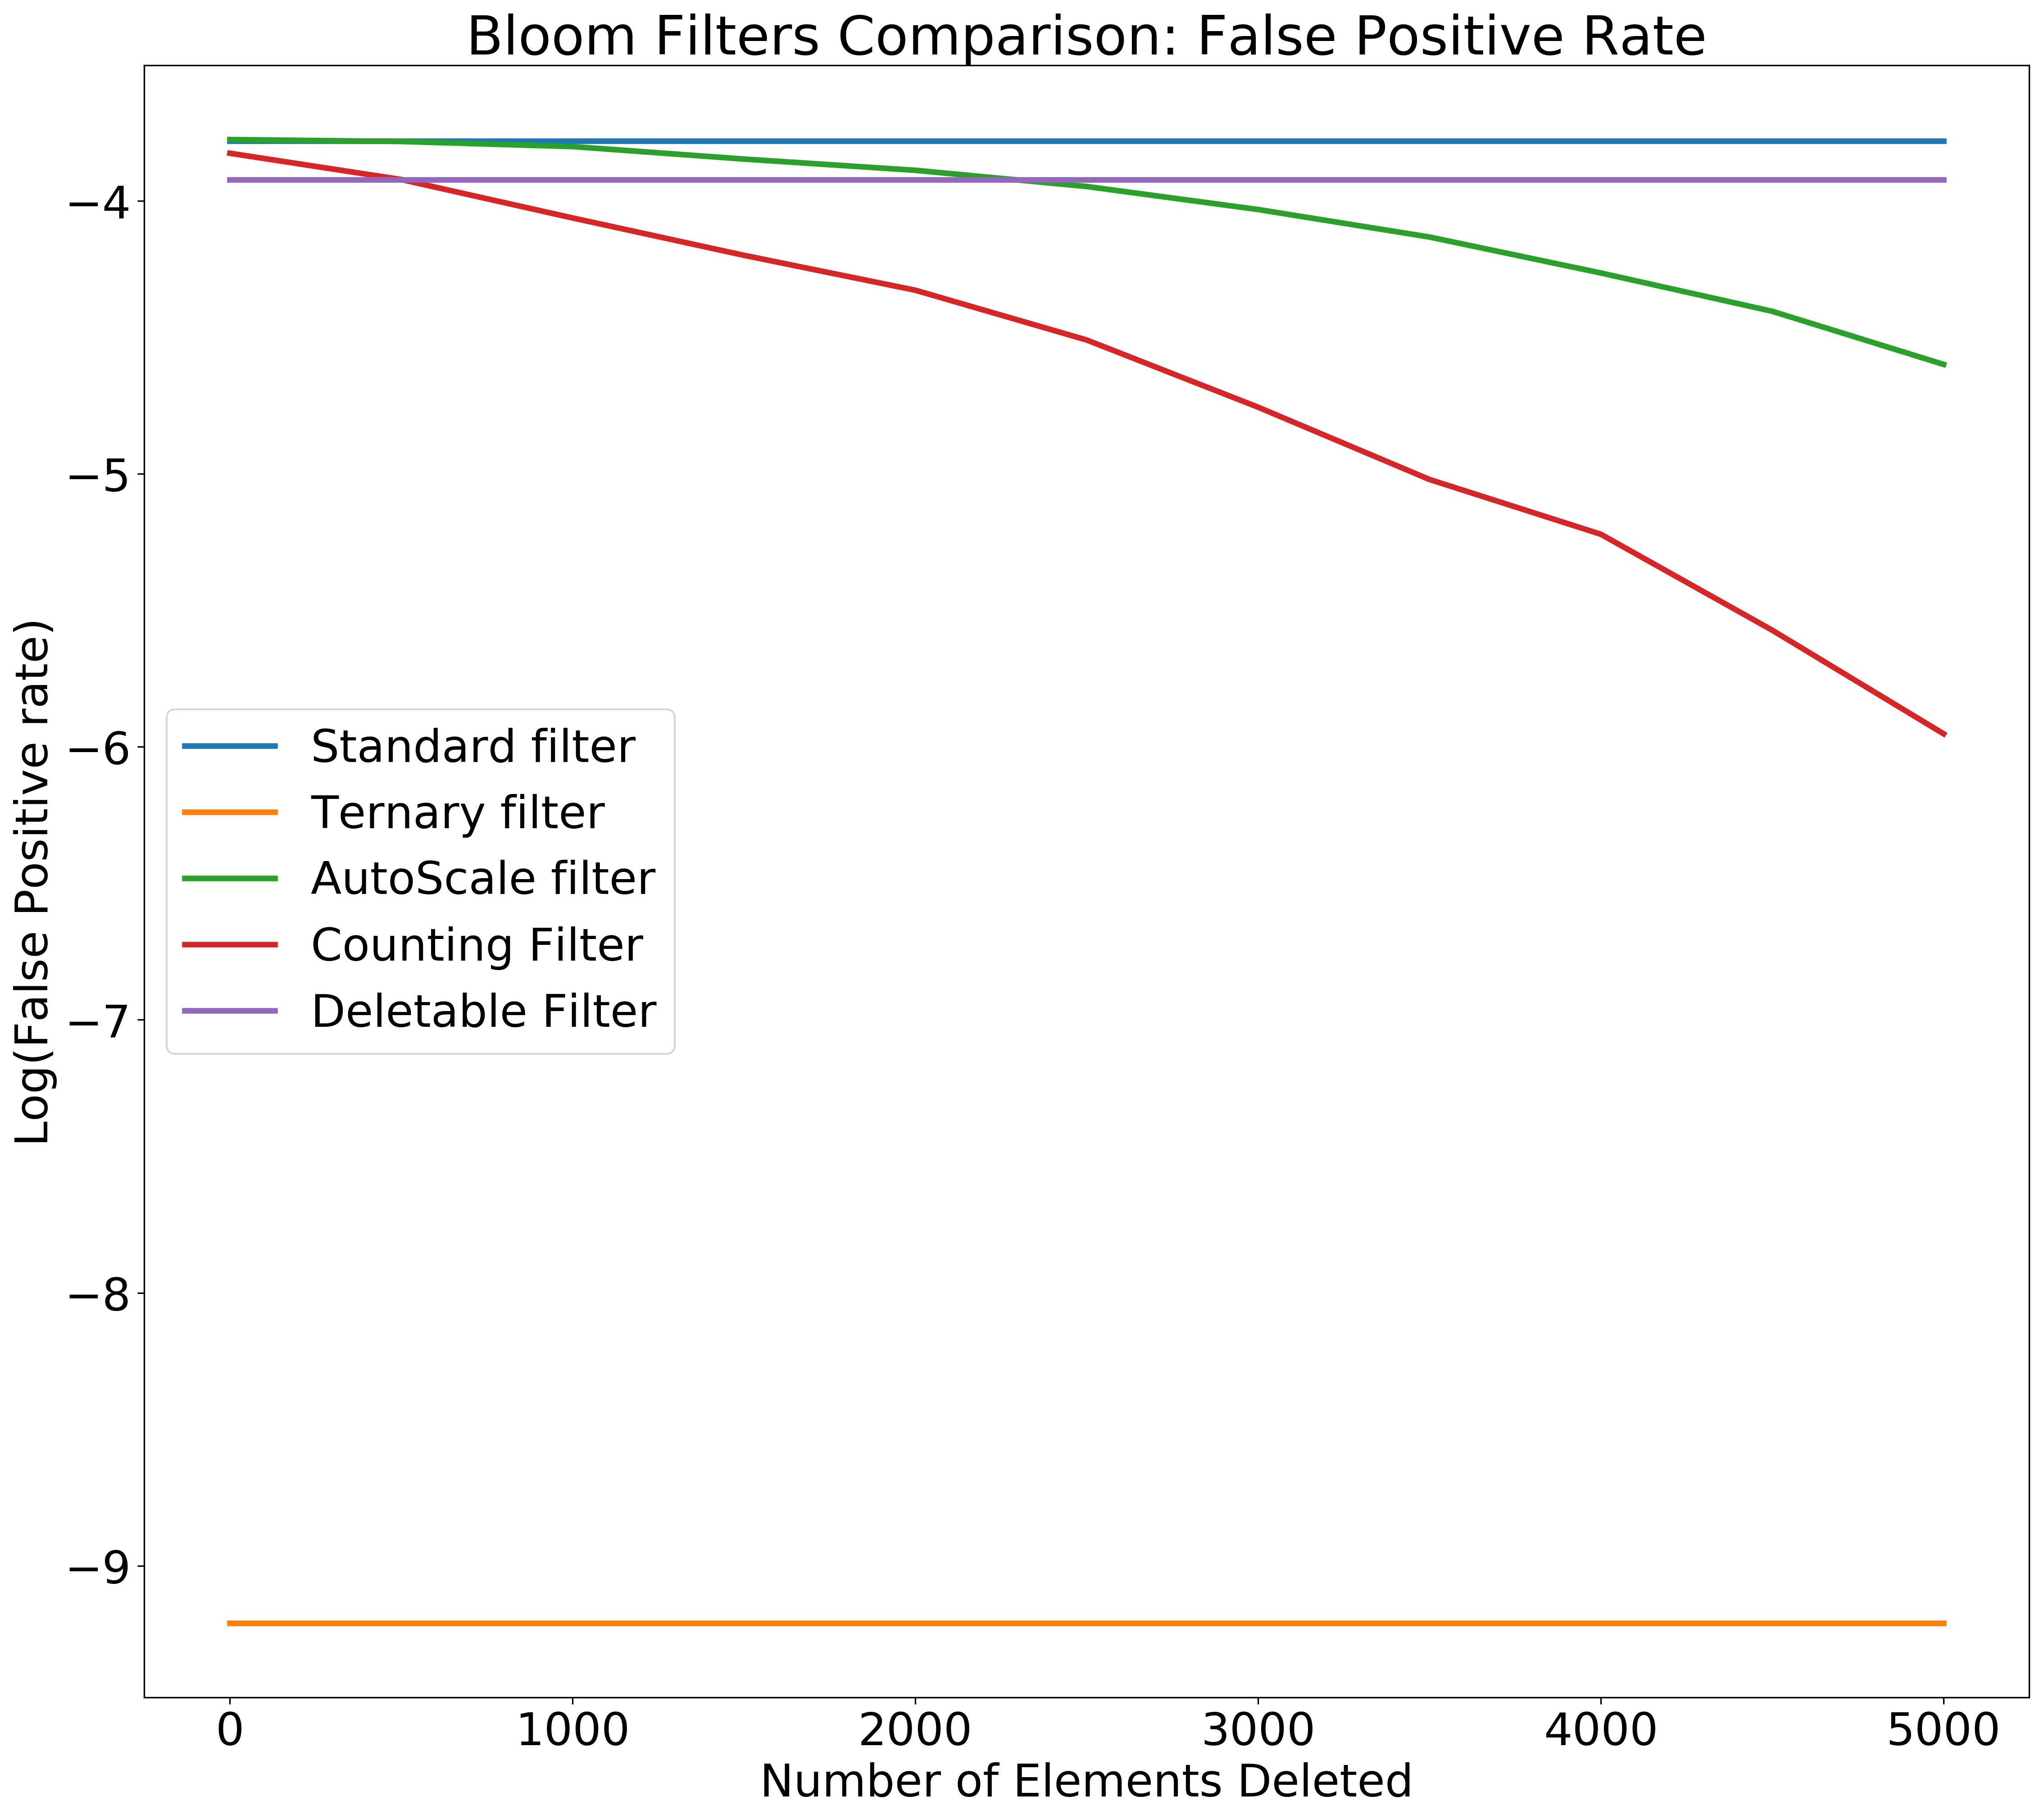

In [298]:
# Generate filter instances
m=100000
filter_list=[[],[],[],[],[]]
filters=[]
I=[]
filters.append(stdFilter(m, 3, m/10))
filters.append(terFilter(m, 3, m/10))
filters.append(autoFilter(m,10,m/10,2,1))
filters.append(countingFilter(m, 3, m/10))
filters.append(deletableFilter(m, 3, m/10,10))
# Add codes to filters
for code in codes:
    for fil in filters:
        fil.insert(code)
# Delete codes and analyse false positives
for i,code in enumerate(codes):
    for fil in [1,2,3,4]:
        filters[fil].delete(code)
    if(i%500==0):
        for ind,fil in enumerate(filters):
            fp=0
            for c in check_code:
                if(fil!=1):
                    if(not fil.queryFilter(c)):
                        fp+=1
                else:
                    if(fil.queryFilter(c)==1):
                        fp+=1
            
            if(ind==2):
                filter_list[ind].append(float(fp)/float(len(check_code)*10))
            else:
                filter_list[ind].append(float(fp)/float(len(check_code)))
        I.append(i)
    if(i==5000):
        break
print(filter_list)
filter_list[1]=np.array(filter_list[1])+0.0001
fig=plt.figure(figsize=(18, 16), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(I,np.log(filter_list[0]),label='Standard filter',linewidth=3)
plt.plot(I,np.log(filter_list[1]),label='Ternary filter',linewidth=3)
plt.plot(I,np.log(filter_list[2]),label='AutoScale filter',linewidth=3)
plt.plot(I,np.log(filter_list[3]),label='Counting Filter',linewidth=3)
plt.plot(I,np.log(filter_list[4]),label='Deletable Filter',linewidth=3)
plt.legend()
plt.rcParams.update({'font.size': 24})
plt.title('Bloom Filters Comparison: False Positive Rate')
plt.xlabel('Number of Elements Deleted')
plt.ylabel('Log(False Positive rate)')
plt.show()

